In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML
# import line_profiler as lp 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import wandb

import sys
sys.path.append('../src')
from model2D_v2 import *
from datagen2D_v2 import *
from analysis_v2 import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()
# torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision("high")

/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on GPU:  cuda:0
Running on GPU:  cuda:0


/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/d

Running on GPU:  cuda:0


In [ ]:
# constant_2D_ratinaboxnew_1000_40_256.npy, gradual_2D_ratinabox_2000_10_64.npy, 
# gradual_2D_ratinabox_5000_25_64.npy, constant_2D_ratinaboxnew_400_300_64.npy
# constant_2D_ratinaboxnew_1000_40_256.npy, constant_2D_bounded_hdv_randomstart_1000_40_256.npy
# constant_2D_5000_40_256.npy

In [25]:
config = {
    "learning_rate": 0.0002,
    "architecture": "CfC_NCP_LSTM_Low",
    "dataset": "gradual_2D_ratinabox_5000_25_64.npy",
    "dataset_generator": "datagen2D_OU",
    "low": True,
    "lstm": True,  
    "hidden_size": 256,
    "act_decay": 0.0,
    "weight_decay": 0.00,
    "act_decay_to_one": False,
    "h_bias": False,
    "input_bias": True,
    "rest_bias": None,
    "irnn": False,
    "activation": None,
    "clip_grad": 1.0,
    "optimizer": "SophiaG",
    "scheduler": "StepLR",
    "if_scheduler": True,
    "scheduler_gamma" : 0.5,
    "scheduler_step" : 500,
    }

In [3]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="RNN-Navigation-Representations",
    
    # track hyperparameters and run metadata
    config=config,
    resume=True
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: mattis-dalsaetra. Use `wandb login --relogin` to force relogin


In [4]:
input_data = np.load("../datasets/" + config.dataset,allow_pickle=True)
config.epochs = input_data.shape[0]
config.batch_size = input_data[0,0].shape[0]
input_data[0,0].shape[0]

256

In [26]:
# lr=0.0002,if_low=False,act_decay=0.0,weight_decay=0.01,act_decay_to_one=False,h_bias=False,input_bias=True,rest_bias=True,irnn=True,activation=True,clip_grad=True,optimizer="Sophia"

lr = config["learning_rate"]
input_size = 2
hidden_size = config["hidden_size"]


model = CfC_NCP(input_size,hidden_size,if_low=config["low"],lr=lr).to(device)
if config["if_scheduler"]:
    model.activate_scheduler(step_size=config["scheduler_step"],gamma=config["scheduler_gamma"])
model_compiled = torch.compile(model)

train = False
if train:
    _ = model_compiled.train_gradual_manual(input_data)
    model.plot_losses(average=30)
    for i in range(len(model.task_losses)):
        wandb.log({"Task_loss": model.task_losses[i], "Total_loss": model.total_losses[i]})
else:
    torch.cuda.empty_cache()
    model.load_state_dict(torch.load("../trained models/CfC_NCP_LSTM_Low_g8de1ucc.pt",map_location=device))
    model.eval()

In [27]:
savemodel = False
logmodel = False

if savemodel:
    model_string = str(config.architecture) + "_" + str(run.id)
    model_path = "../trained models/" + model_string  + ".pt"
    torch.save(model.state_dict(), model_path)

if logmodel:
    model_art = wandb.Artifact(model_string, type='model')
    model_art.add_file(model_path)
    wandb.log_artifact(model_art)

# Analysis

In [6]:
an = Analysis(model,if_low=config.low)

## Activity/hidden state norms per tstep

In [6]:
mean_norms = an.plot_norm(avg_only=False)

for norms in mean_norms:
    wandb.log({'mean_norm_per_tstep': norms})

AttributeError: 'CfC_NCP' object has no attribute 'hts'

## Tuning curves

In [10]:
t_test = 40
test_batch_size = 5000
activity = an.binned_mean_activity(t_test=t_test,test_batch_size=test_batch_size,bins=50)

100%|██████████| 256/256 [00:05<00:00, 50.40it/s]


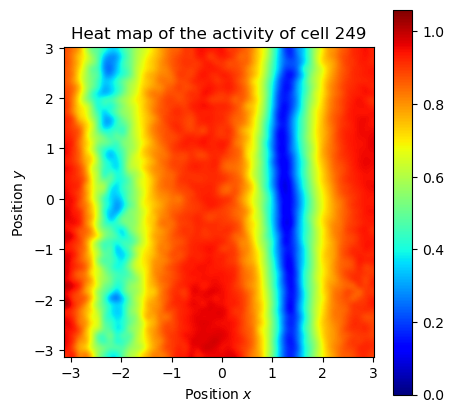

100%|██████████| 16/16 [00:00<00:00, 977.51it/s]


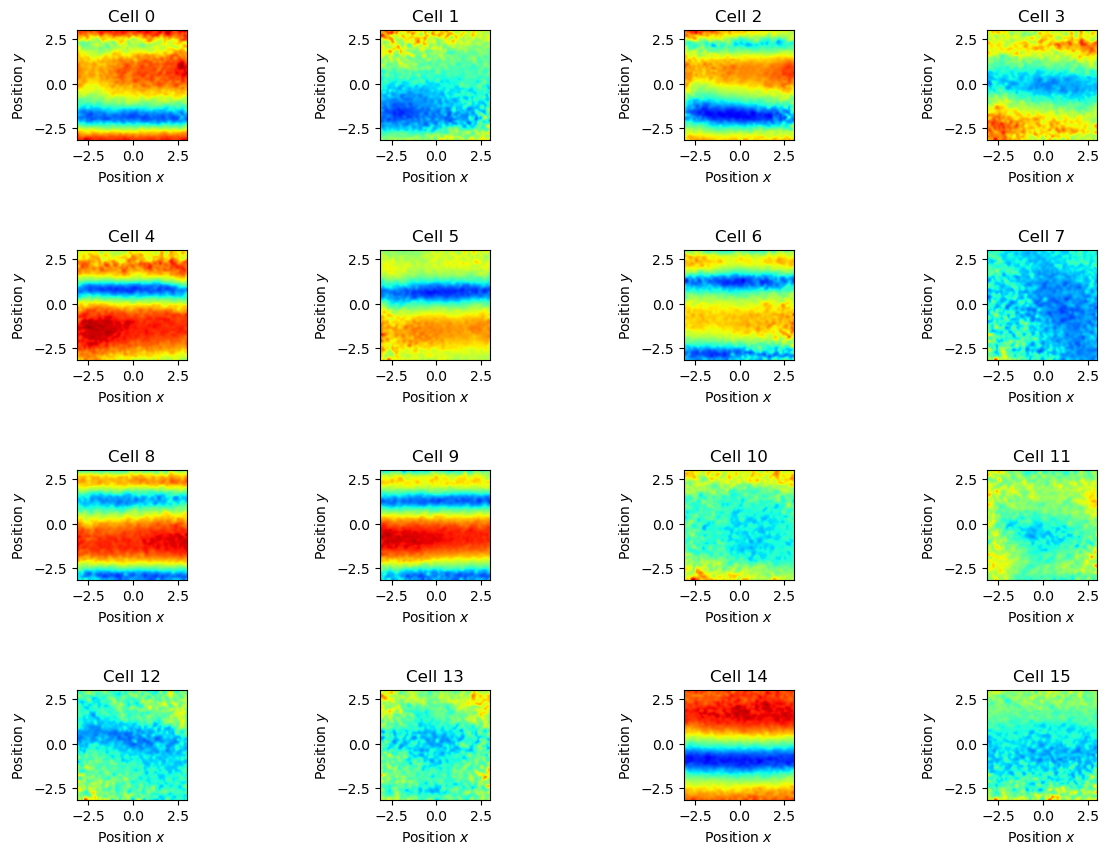

In [8]:
an.plot_2D_activity(k_test=249,more_plots=True,plot_head_frac=1/16)

In [15]:

# cells = [252,254,249,228,250]
cells = range(len(activity))
for cell in cells:
    normalized = (activity[cell] - np.min(activity[cell])) / (np.max(activity[cell]) - np.min(activity[cell]))
    images = wandb.Image(normalized, caption="Tuning Curves")
    wandb.log({"tuning_curves": images})

## Low-D Representation of activity

In [12]:
embedding, reducer = an.lowD_reduce(if_pca=False,n_components=3,plot=True,n_neighbors=500)

(2500, 3)


In [13]:
wandb.log({"Activity Representation": wandb.Object3D(embedding)})

## Path error

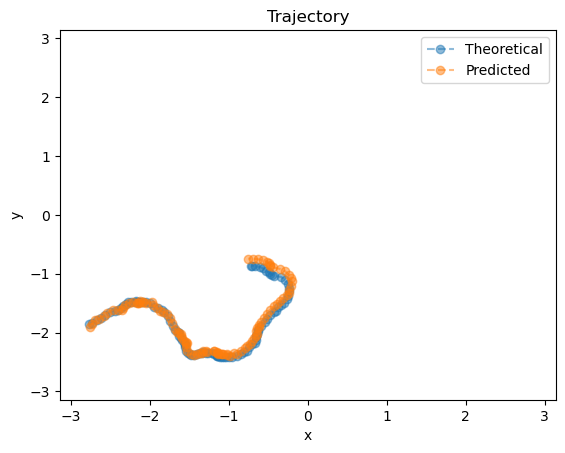

Mean error:  0.11083397
Mean end error:  0.10256348


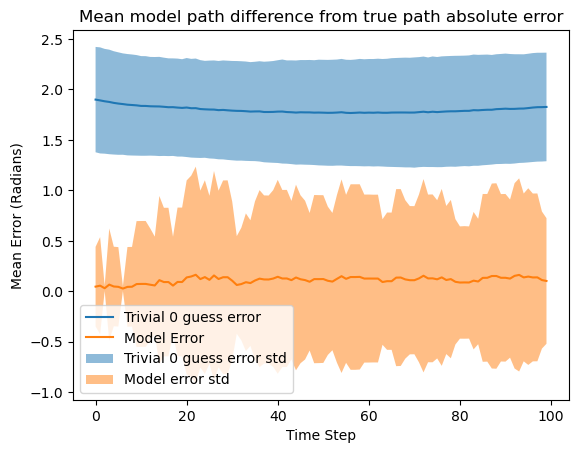

In [9]:
total_mse, path_err_mean, path_err_mean_std = an.eval(test_batch_size=1000,t_test=100,plot_example=True)

In [10]:
wandb.log({"Total MSE Error": total_mse})
for i in range(len(path_err_mean)):
    wandb.log({"Path MSE Error": path_err_mean[i]})
    wandb.log({"Path MSE Error STD": path_err_mean_std[i]})

In [11]:
run.finish()

Path MSE Error,▂▁▂▂▃▃▄▂▇█▅▆▅▄▅▆▇▅▆▆▆▆▆▇▆▄▇▆▆▆▇▆▄▅▆▇▆█▇▅
Path MSE Error STD,▃▁▃▃▅▅▆▄▇█▆▇▆▅▆▆▇▆▆▆▆▆▆▇▆▅▇▆▆▆▇▆▅▅▆▇▆▇▆▅
Total MSE Error,▁
Path MSE Error,0.10256
Path MSE Error STD,0.62224
Total MSE Error,0.27679
